# Ablation Study

In [ ]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import optuna
import optuna.visualization as vis
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

### ConvNeXt-Tiny (SimCLR + ImageNet-1k)


# Classification Report
                           precision    recall  f1-score   support

       Cashew_anthracnose     0.9884    0.9827    0.9855       173
           Cashew_gumosis     1.0000    0.9744    0.9870        39
           Cashew_healthy     0.9855    0.9927    0.9891       137
          Cashew_red rust     1.0000    1.0000    1.0000       168
 Cassava_bacterial blight     0.9618    0.9692    0.9655       260
       Cassava_brown spot     0.9650    0.9388    0.9517       147
          Cassava_healthy     0.9756    1.0000    0.9877       120
           Cassava_mosaic     1.0000    1.0000    1.0000       112
            Maize_healthy     0.8333    1.0000    0.9091        20
        Maize_leaf blight     0.9388    0.9388    0.9388        98
          Maize_leaf spot     0.9278    0.8654    0.8955       104
       Maize_streak virus     0.9362    0.9670    0.9514        91
           Tomato_healthy     0.9362    0.9565    0.9462        46
       Tomato_leaf blight     0.8031

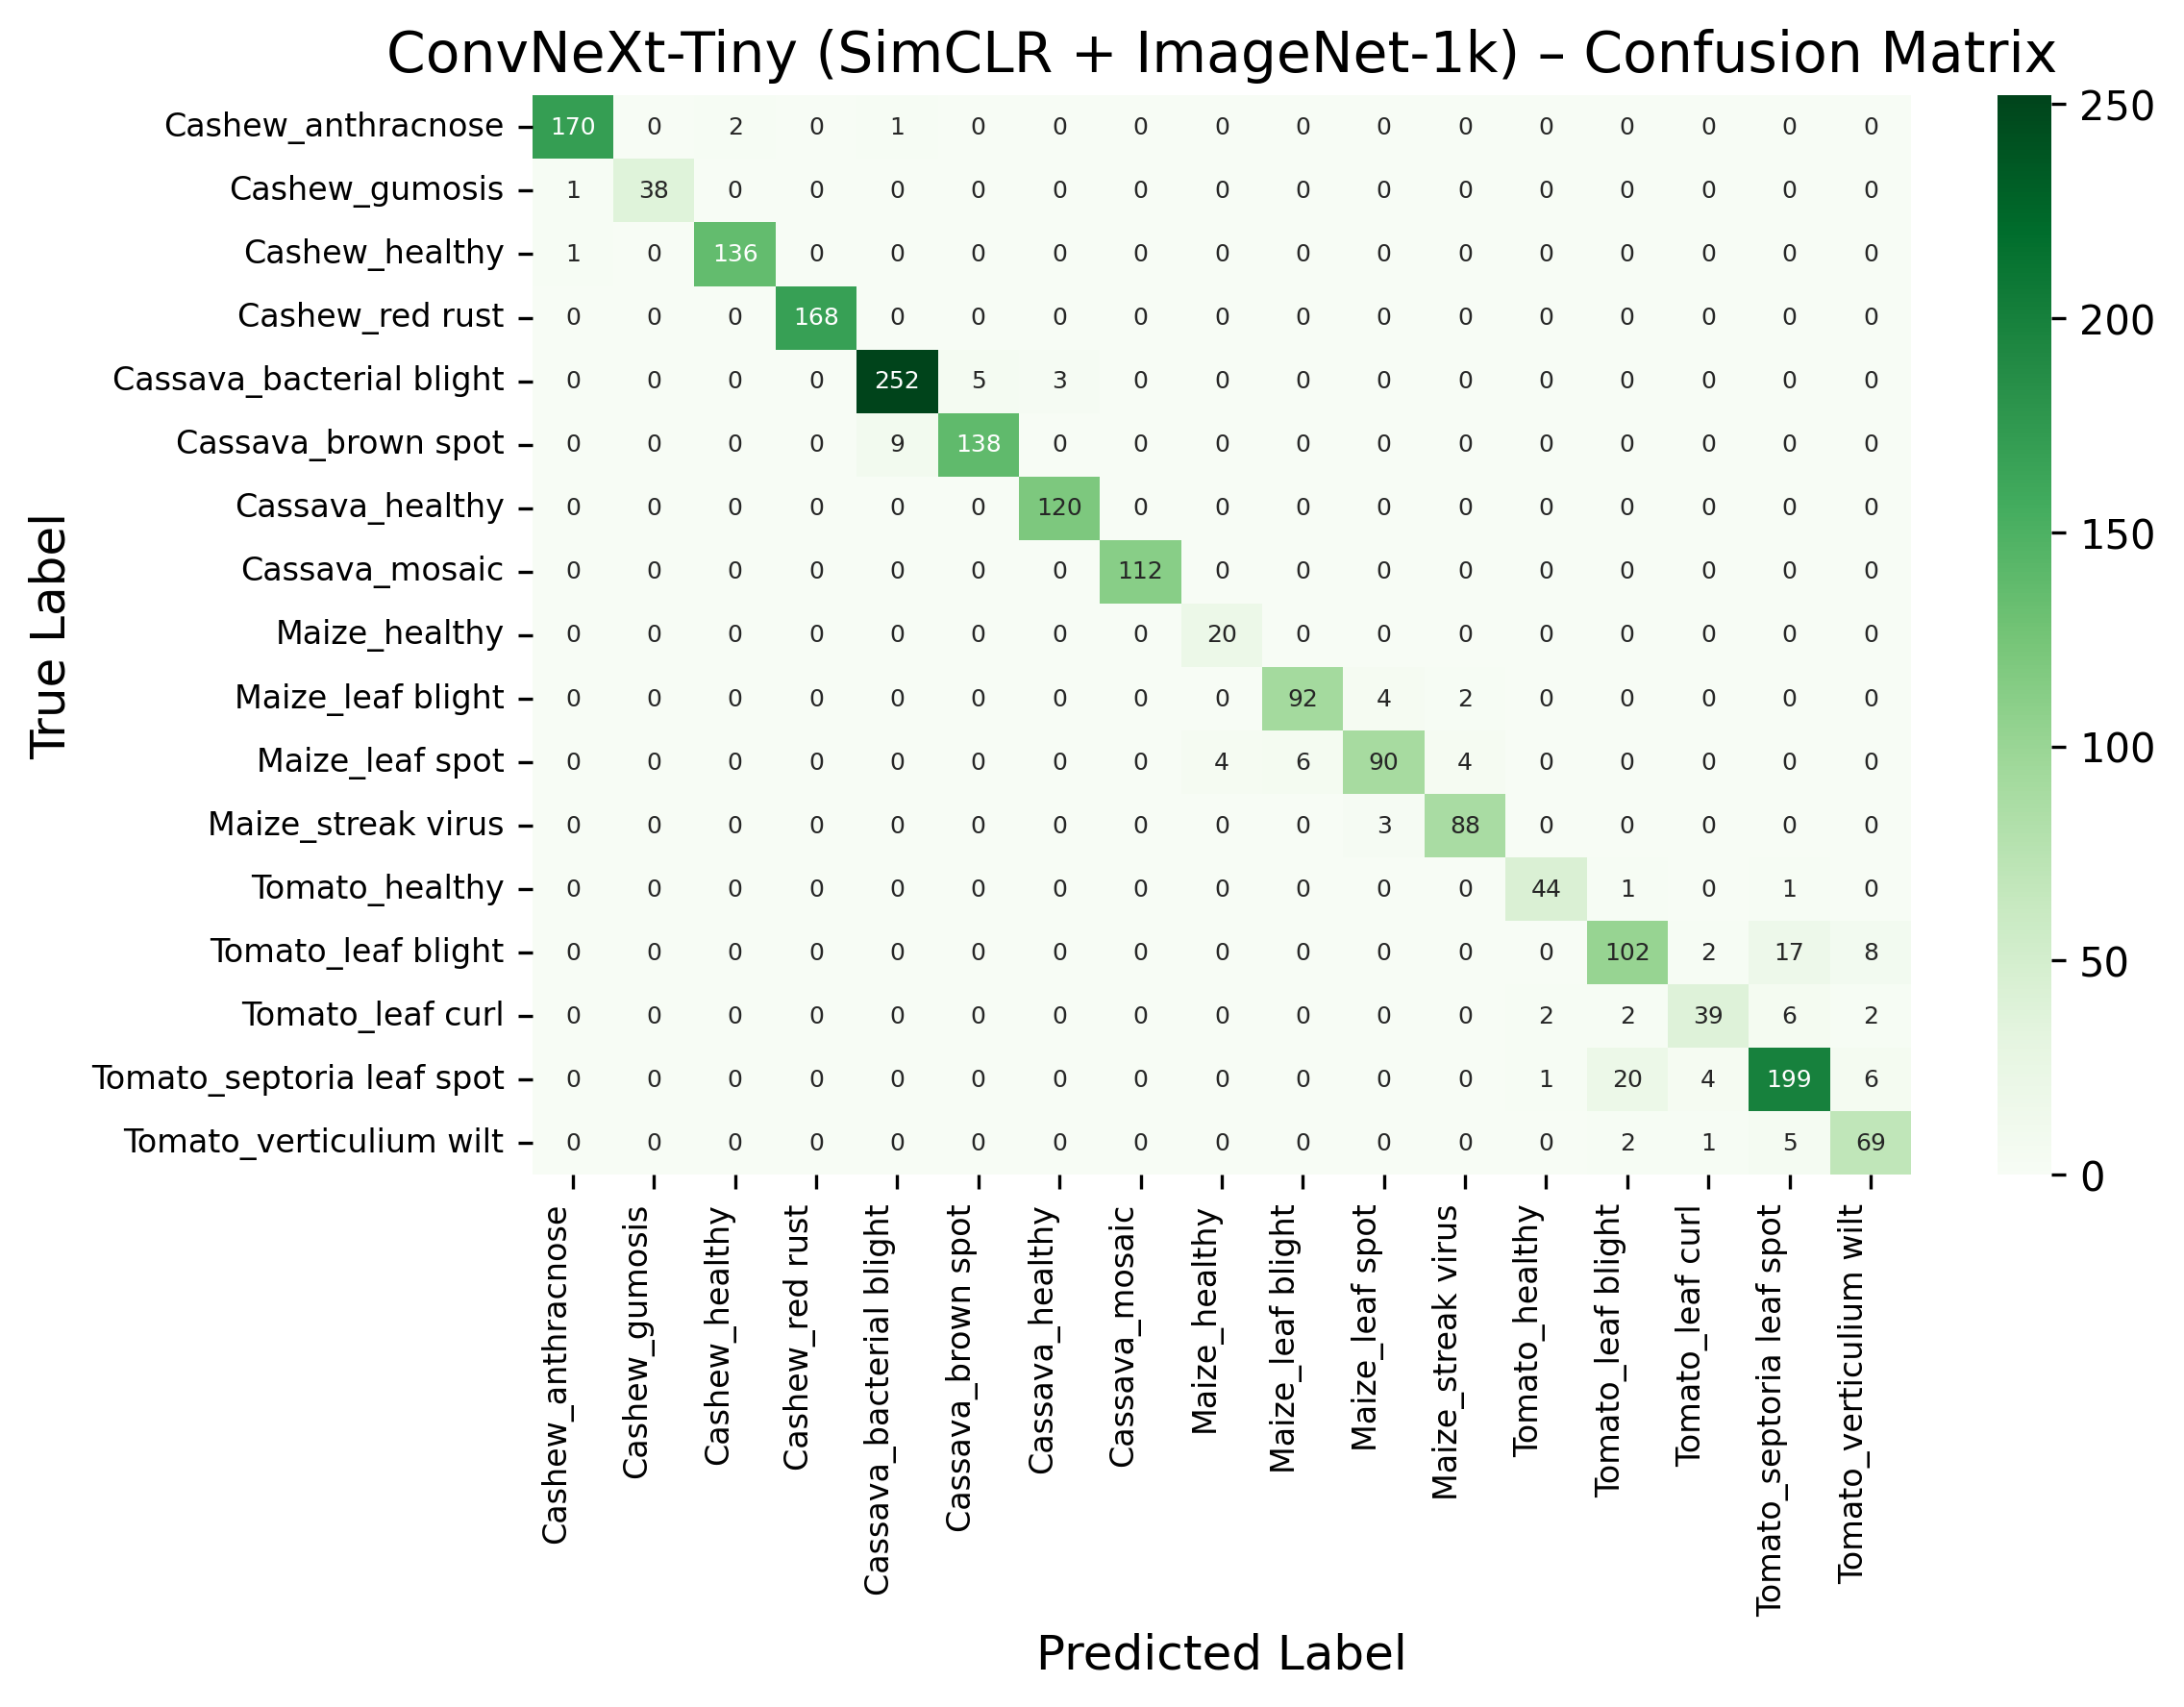

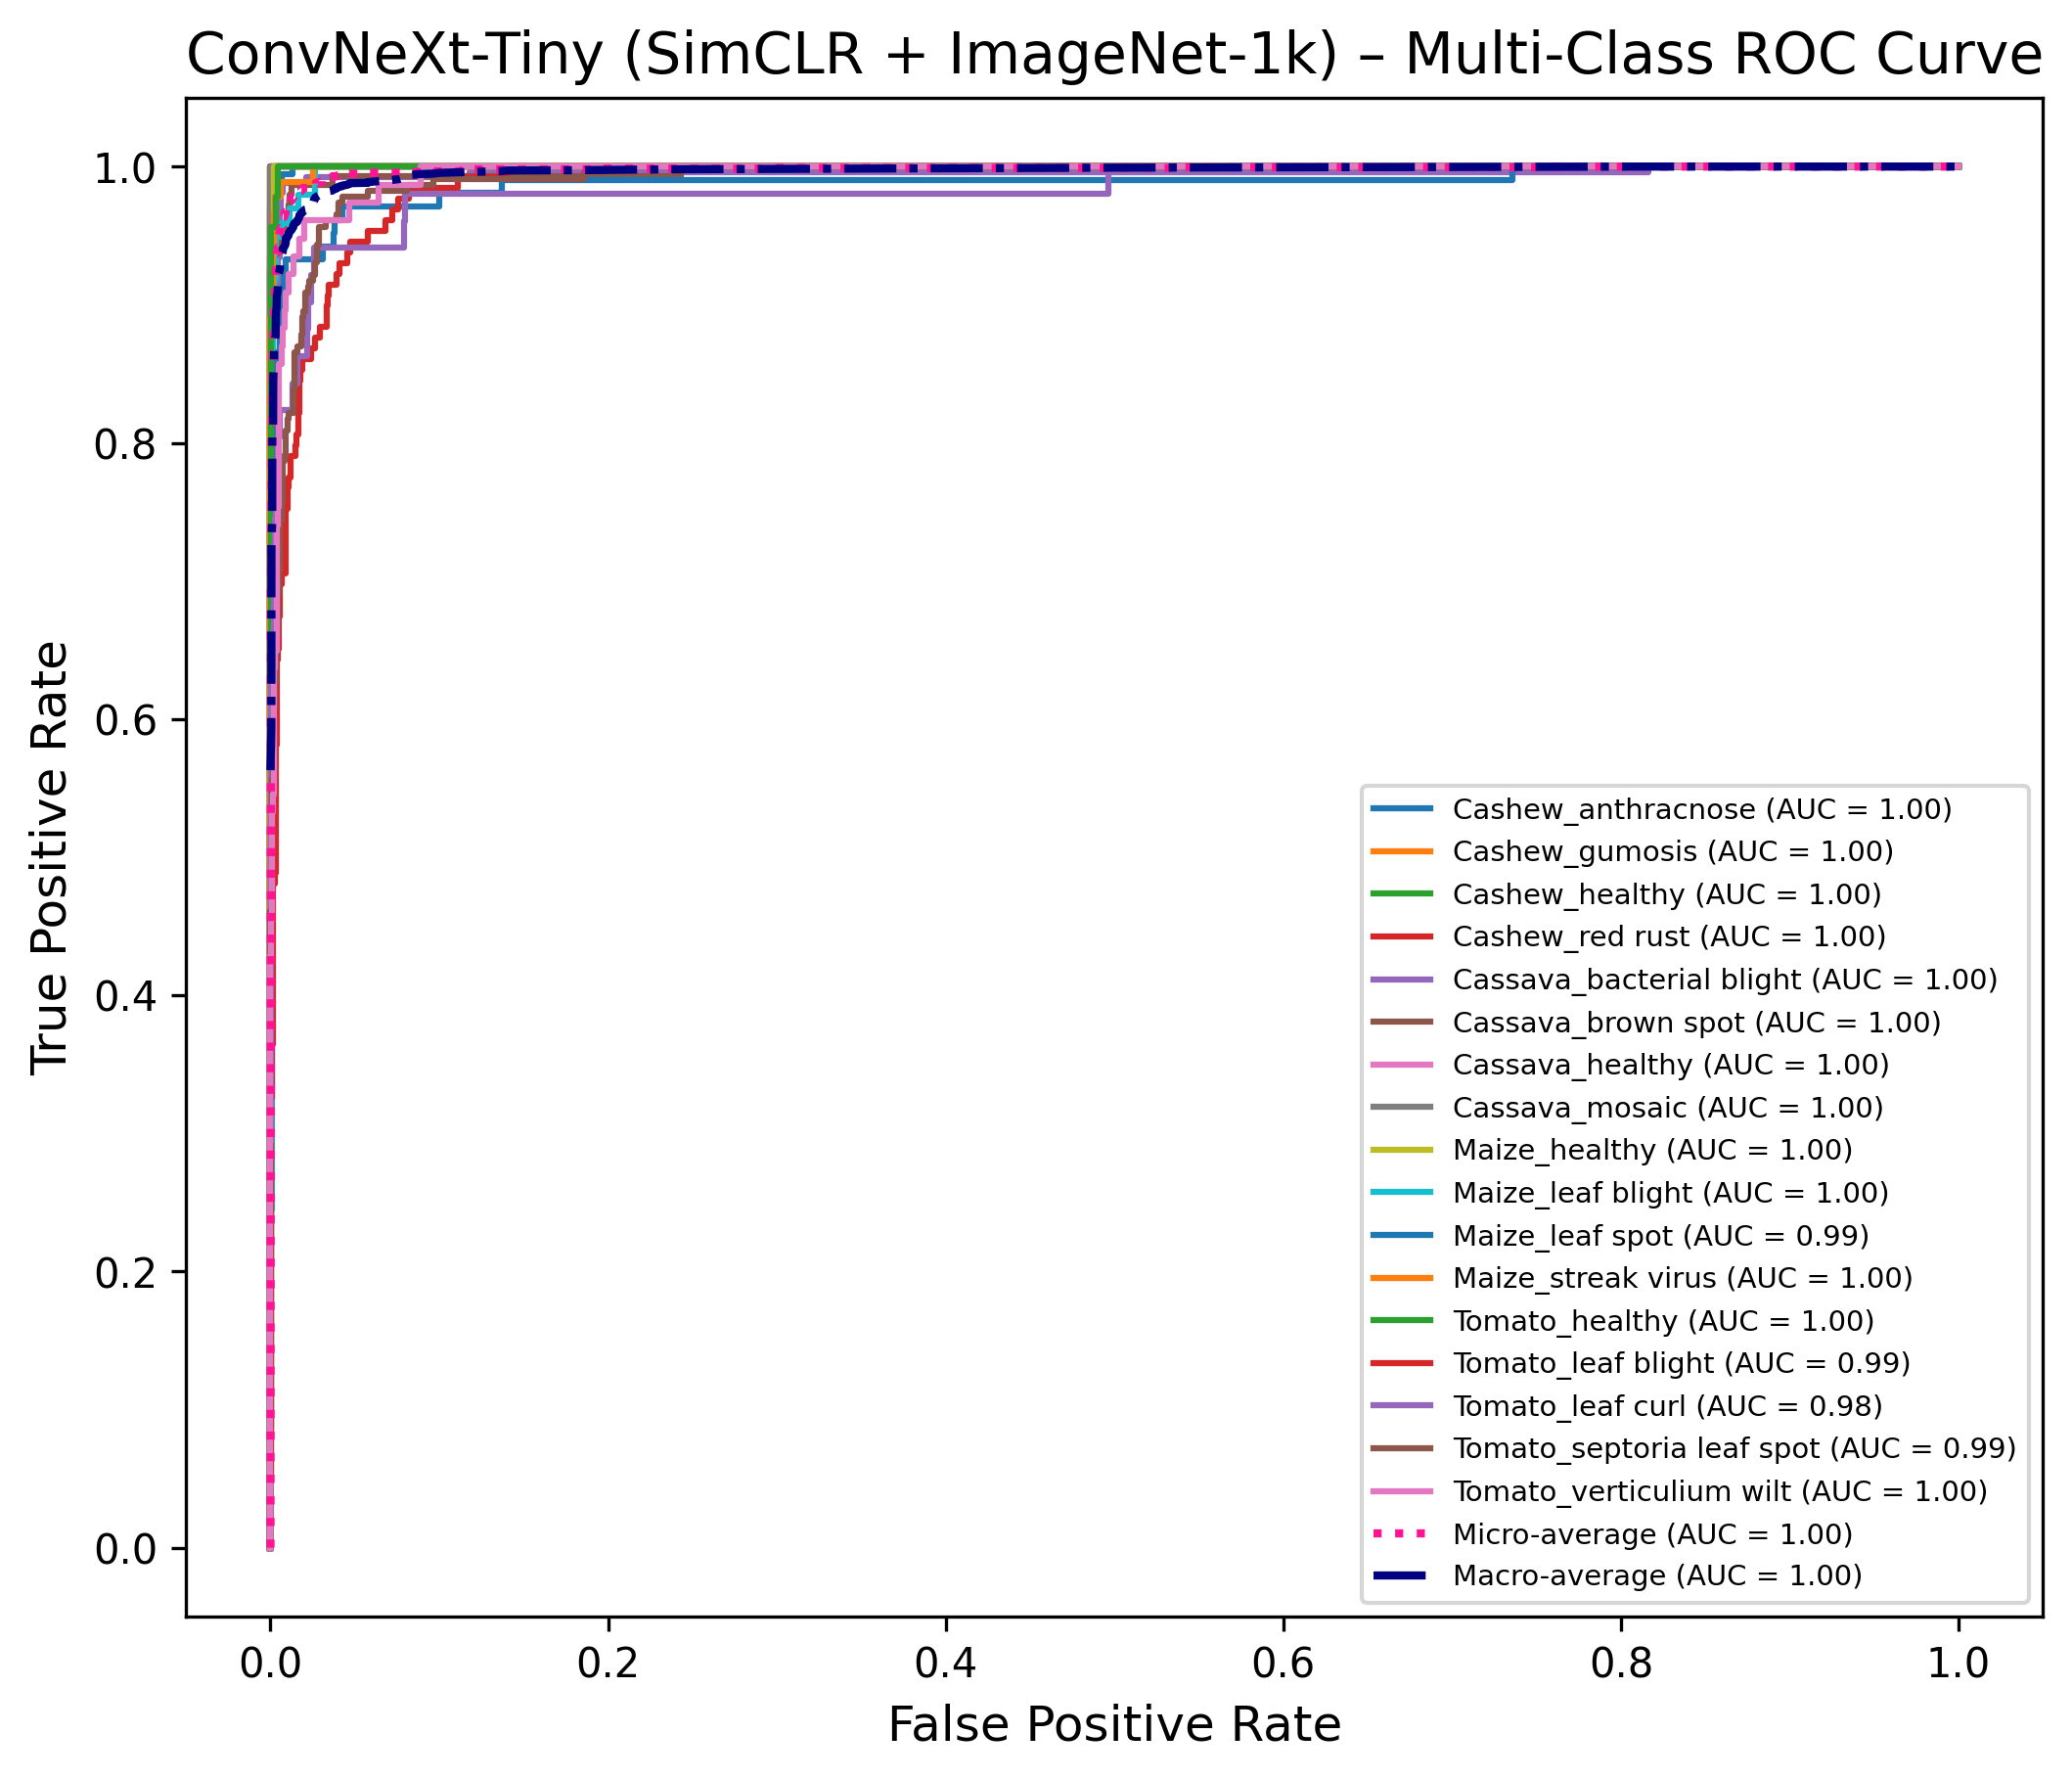

In [56]:
# define paths for loading predictions, targets, and saving plots
version_dir = r"c:/users/xuxu/desktop/master thesis/simclrbaselineimagenet/single_run/version_0"
index_dir = r"c:/users/xuxu/desktop/master thesis/optunadensenetfull"
save_dir = os.path.join(version_dir, "figures")

# create the directory for saving plots if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# paths to model outputs
preds_path = os.path.join(version_dir, "all_preds.npy")
targets_path = os.path.join(version_dir, "all_targets.npy")
probs_path = os.path.join(version_dir, "all_probs.npy")
metrics_path = os.path.join(version_dir, "test_metrics.json")

# load class-to-index mapping and convert to index-to-class
with open(os.path.join(index_dir, "class_to_idx.json")) as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# load model predictions, true targets, and class probabilities
all_preds = np.load(preds_path)
all_targets = np.load(targets_path)
all_probs = np.load(probs_path)

# print detailed classification report
print("\n# classification report")
print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

# create and save confusion matrix heatmap
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="greens",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"fontsize": 6}
)
plt.title("convnext-tiny (simclr + imagenet-1k) – confusion matrix", fontsize=14)
plt.xlabel("predicted label", fontsize=12)
plt.ylabel("true label", fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(save_dir, "confusion_matrix_absolute_cleaned.png"), bbox_inches="tight")
plt.show()

# prepare for multi-class roc curve calculation
n_classes = len(class_names)
y_true_bin = label_binarize(all_targets, classes=list(range(n_classes)))

# calculate roc curve and auc for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# calculate micro-average roc
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# calculate macro-average roc
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot multi-class roc curve with individual and average curves
plt.figure(figsize=(7, 6), dpi=300)

# plot roc for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (auc = {roc_auc[i]:.2f})",
             linewidth=1.5)

# plot micro- and macro-average roc
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average (auc = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=2)
plt.plot(fpr["macro"], tpr["macro"],
         label=f"macro-average (auc = {roc_auc['macro']:.2f})",
         color='navy', linestyle='-.', linewidth=2)

# add titles, labels, and legends
plt.title("convnext-tiny (simclr + imagenet-1k) – multi-class roc curve", fontsize=14)
plt.xlabel("false positive rate", fontsize=12)
plt.ylabel("true positive rate", fontsize=12)
plt.legend(loc="lower right", fontsize=7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=0.5)
plt.savefig(os.path.join(save_dir, "roc_curve_simclr.png"), bbox_inches="tight", dpi=300)
plt.show()



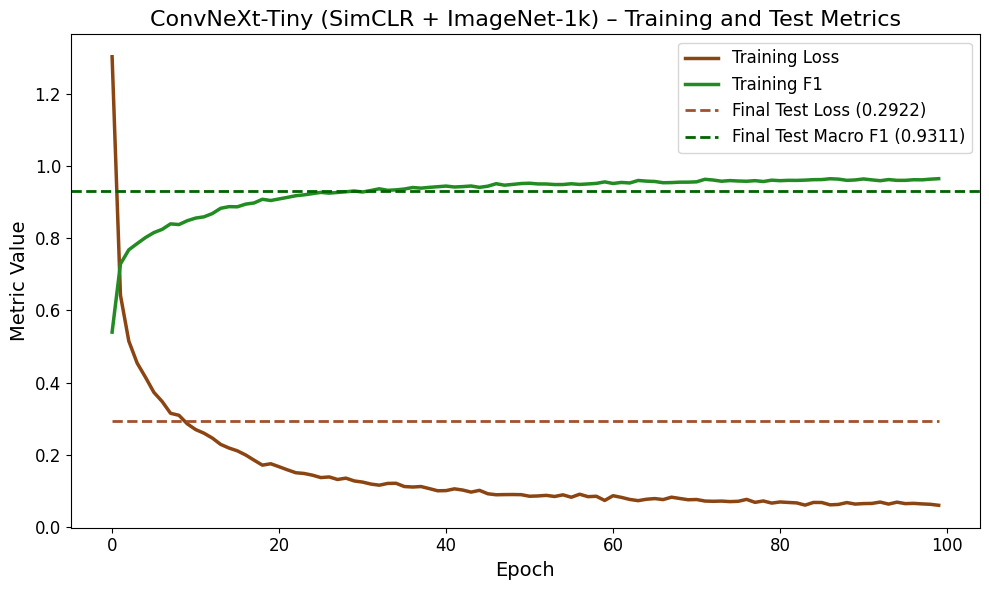

In [58]:
# load metrics and filter rows with valid training loss and f1 values
df = pd.read_csv(metrics_path)
df_epoch = df.dropna(subset=["train_loss", "train_f1"]).reset_index(drop=True)

# load predictions and targets, then compute macro-averaged f1 score
all_preds = np.load(preds_path)
all_targets = np.load(targets_path)
report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
macro_f1 = report["macro avg"]["f1-score"]

# initialize the figure for plotting training and test metrics
plt.figure(figsize=(10, 6))

# plot training loss across epochs
plt.plot(
    df_epoch["epoch"],
    df_epoch["train_loss"],
    label="training loss",
    linestyle="-",
    color="#8b4513",  # saddlebrown
    linewidth=2.5
)

# plot training f1 score across epochs
plt.plot(
    df_epoch["epoch"],
    df_epoch["train_f1"],
    label="training f1",
    linestyle="-",
    color="#228b22",  # forestgreen
    linewidth=2.5
)

# plot horizontal line for final test loss, if available
if "test_loss" in df.columns and not df["test_loss"].isnull().all():
    test_loss = df["test_loss"].dropna().values[-1]
    plt.hlines(
        y=test_loss,
        xmin=df_epoch["epoch"].min(),
        xmax=df_epoch["epoch"].max(),
        label=f"final test loss ({test_loss:.4f})",
        colors="#a0522d",  # sienna
        linestyles="--",
        linewidth=2.0
    )

# plot horizontal line for final macro f1 score
plt.axhline(
    y=macro_f1,
    xmin=0,
    xmax=1,
    label=f"final test macro f1 ({macro_f1:.4f})",
    color="#006400",  # darkgreen
    linestyle="--",
    linewidth=2.0
)

# final formatting for the plot
plt.xlabel("epoch", fontsize=14)
plt.ylabel("metric value", fontsize=14)
plt.title("convnext-tiny (simclr + imagenet-1k) – training and test metrics", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()

# save the plot and display it
save_path = os.path.join(save_dir, "convnext_training_metrics.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


### ConvNext-Tiny ( BYOL + ImageNet-1k) 


# Classification Report
                           precision    recall  f1-score   support

       Cashew_anthracnose     0.9805    0.8728    0.9235       173
           Cashew_gumosis     0.8837    0.9744    0.9268        39
           Cashew_healthy     0.9366    0.9708    0.9534       137
          Cashew_red rust     0.9649    0.9821    0.9735       168
 Cassava_bacterial blight     0.9163    0.8000    0.8542       260
       Cassava_brown spot     0.8155    0.9320    0.8698       147
          Cassava_healthy     0.9200    0.9583    0.9388       120
           Cassava_mosaic     0.9000    0.9643    0.9310       112
            Maize_healthy     0.5333    0.8000    0.6400        20
        Maize_leaf blight     0.7404    0.7857    0.7624        98
          Maize_leaf spot     0.7284    0.5673    0.6378       104
       Maize_streak virus     0.8384    0.9121    0.8737        91
           Tomato_healthy     0.7636    0.9130    0.8317        46
       Tomato_leaf blight     0.6698

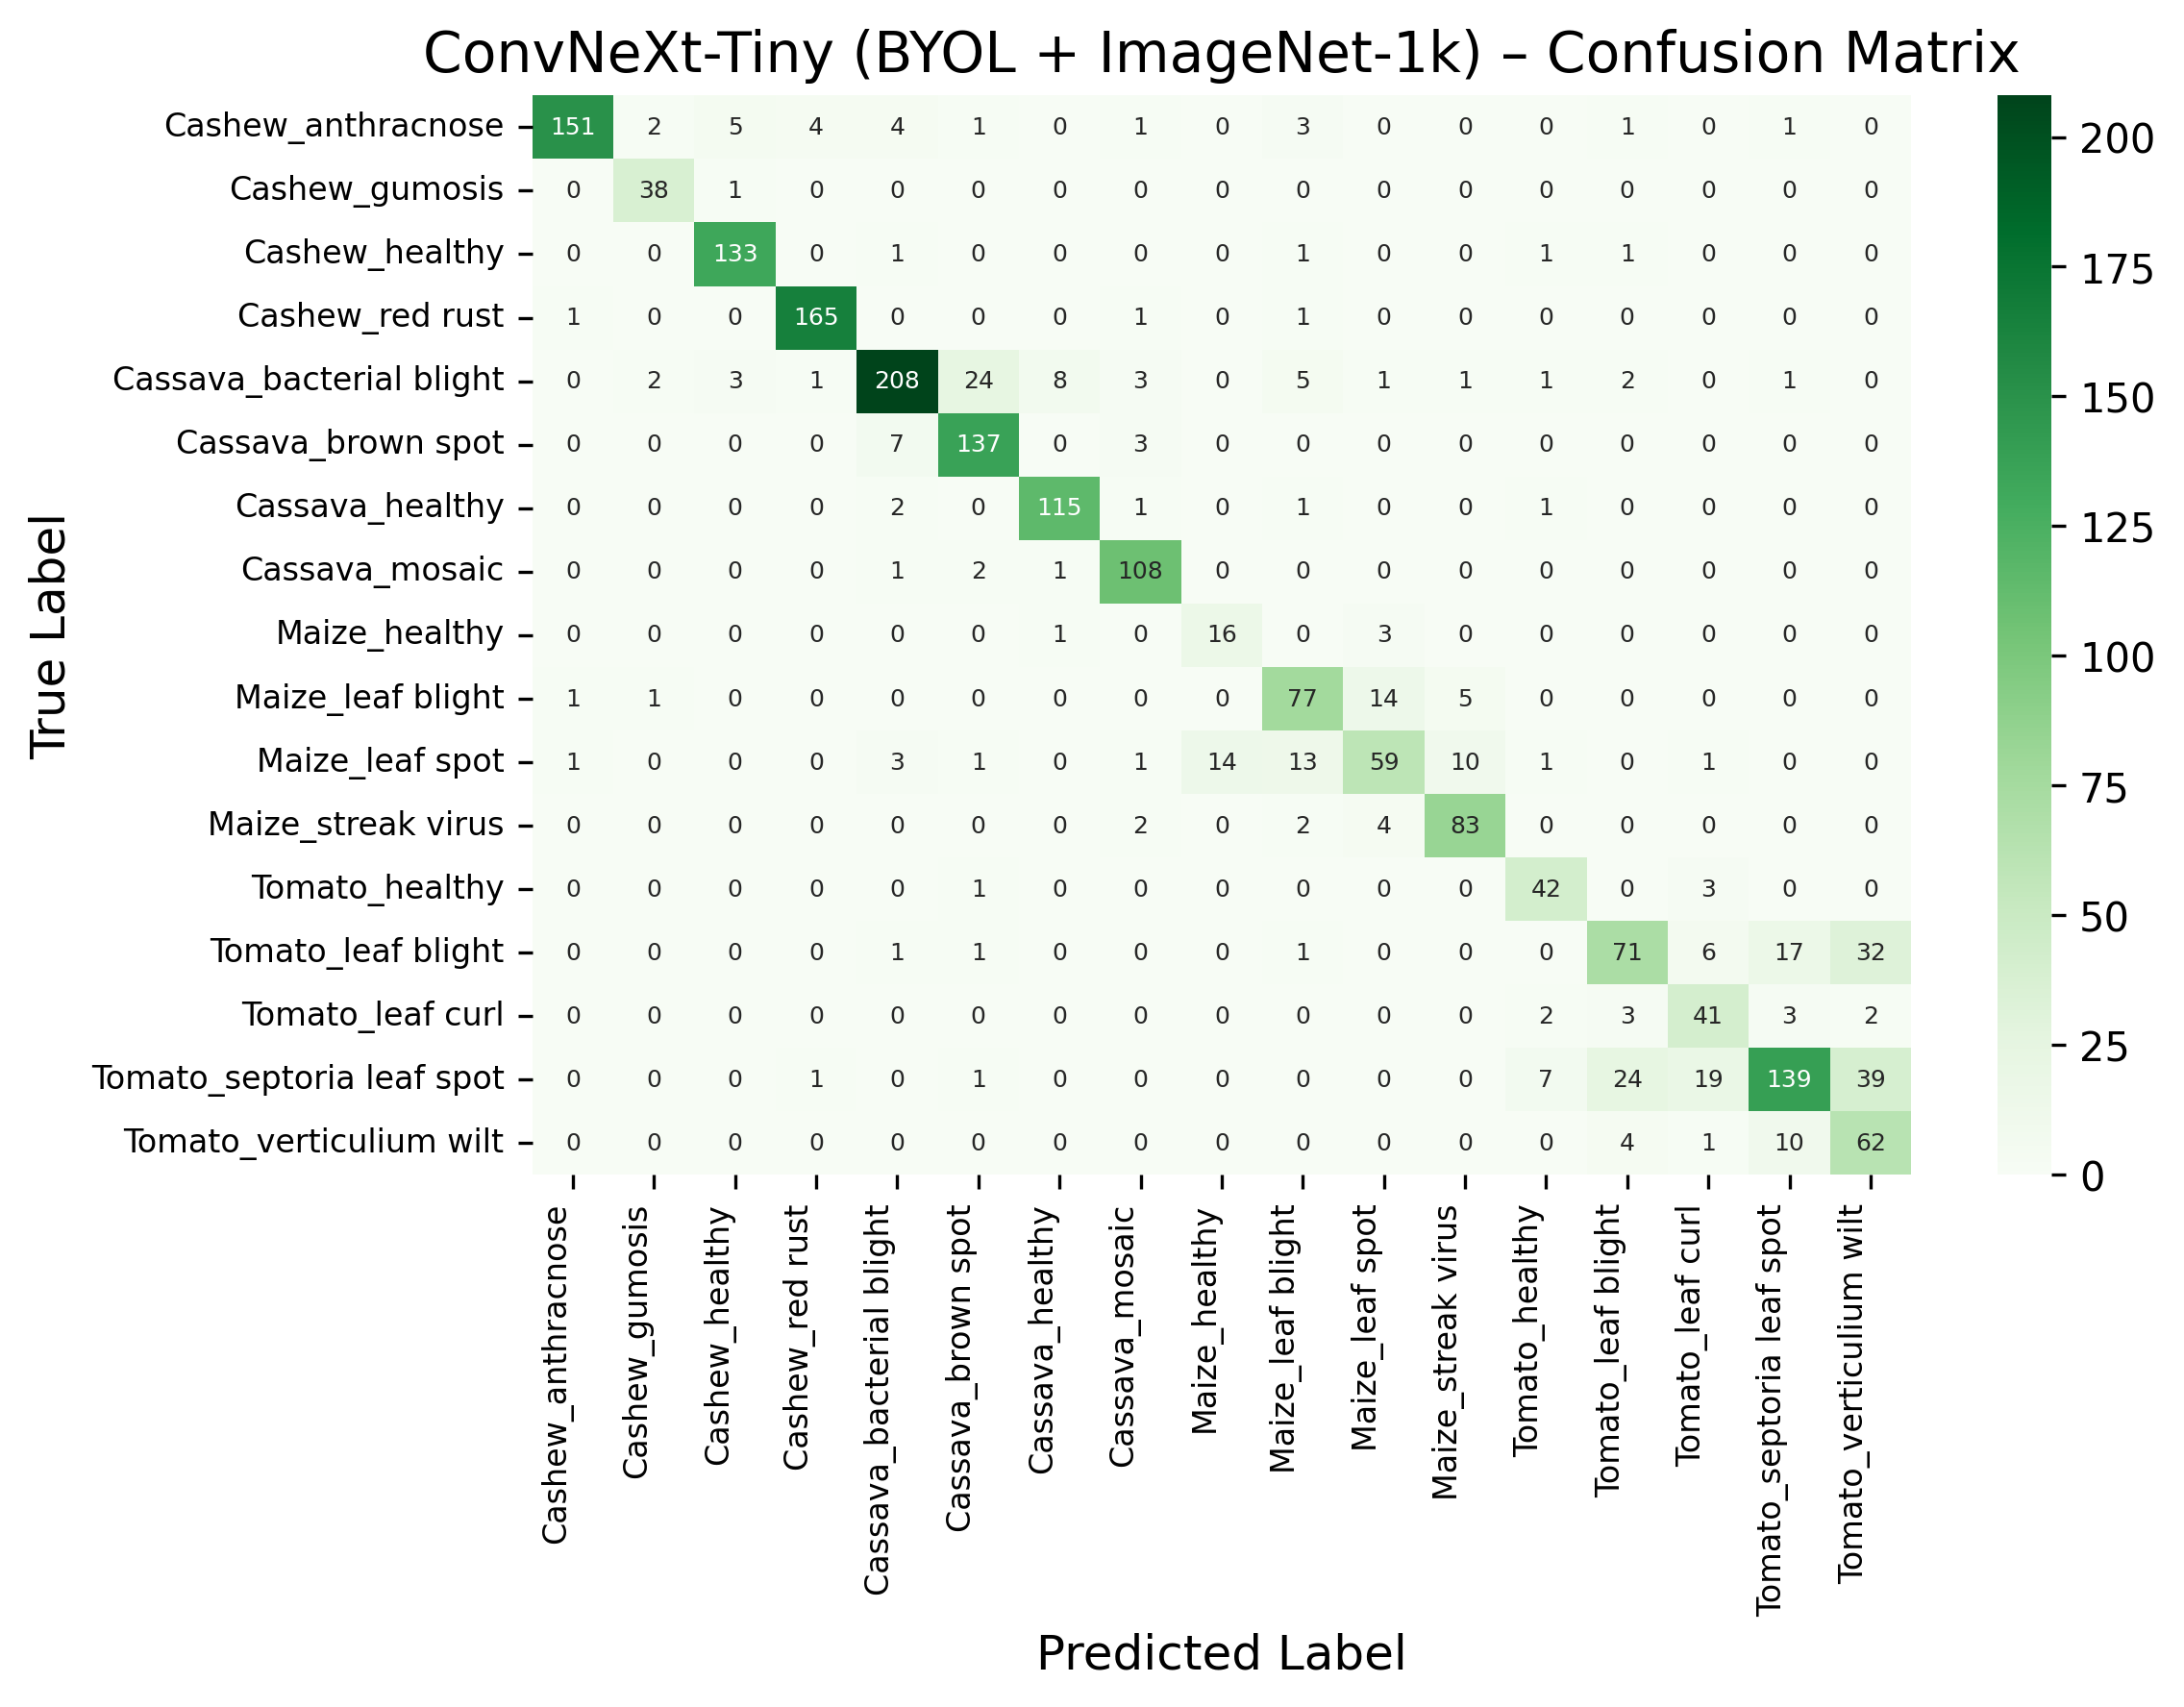

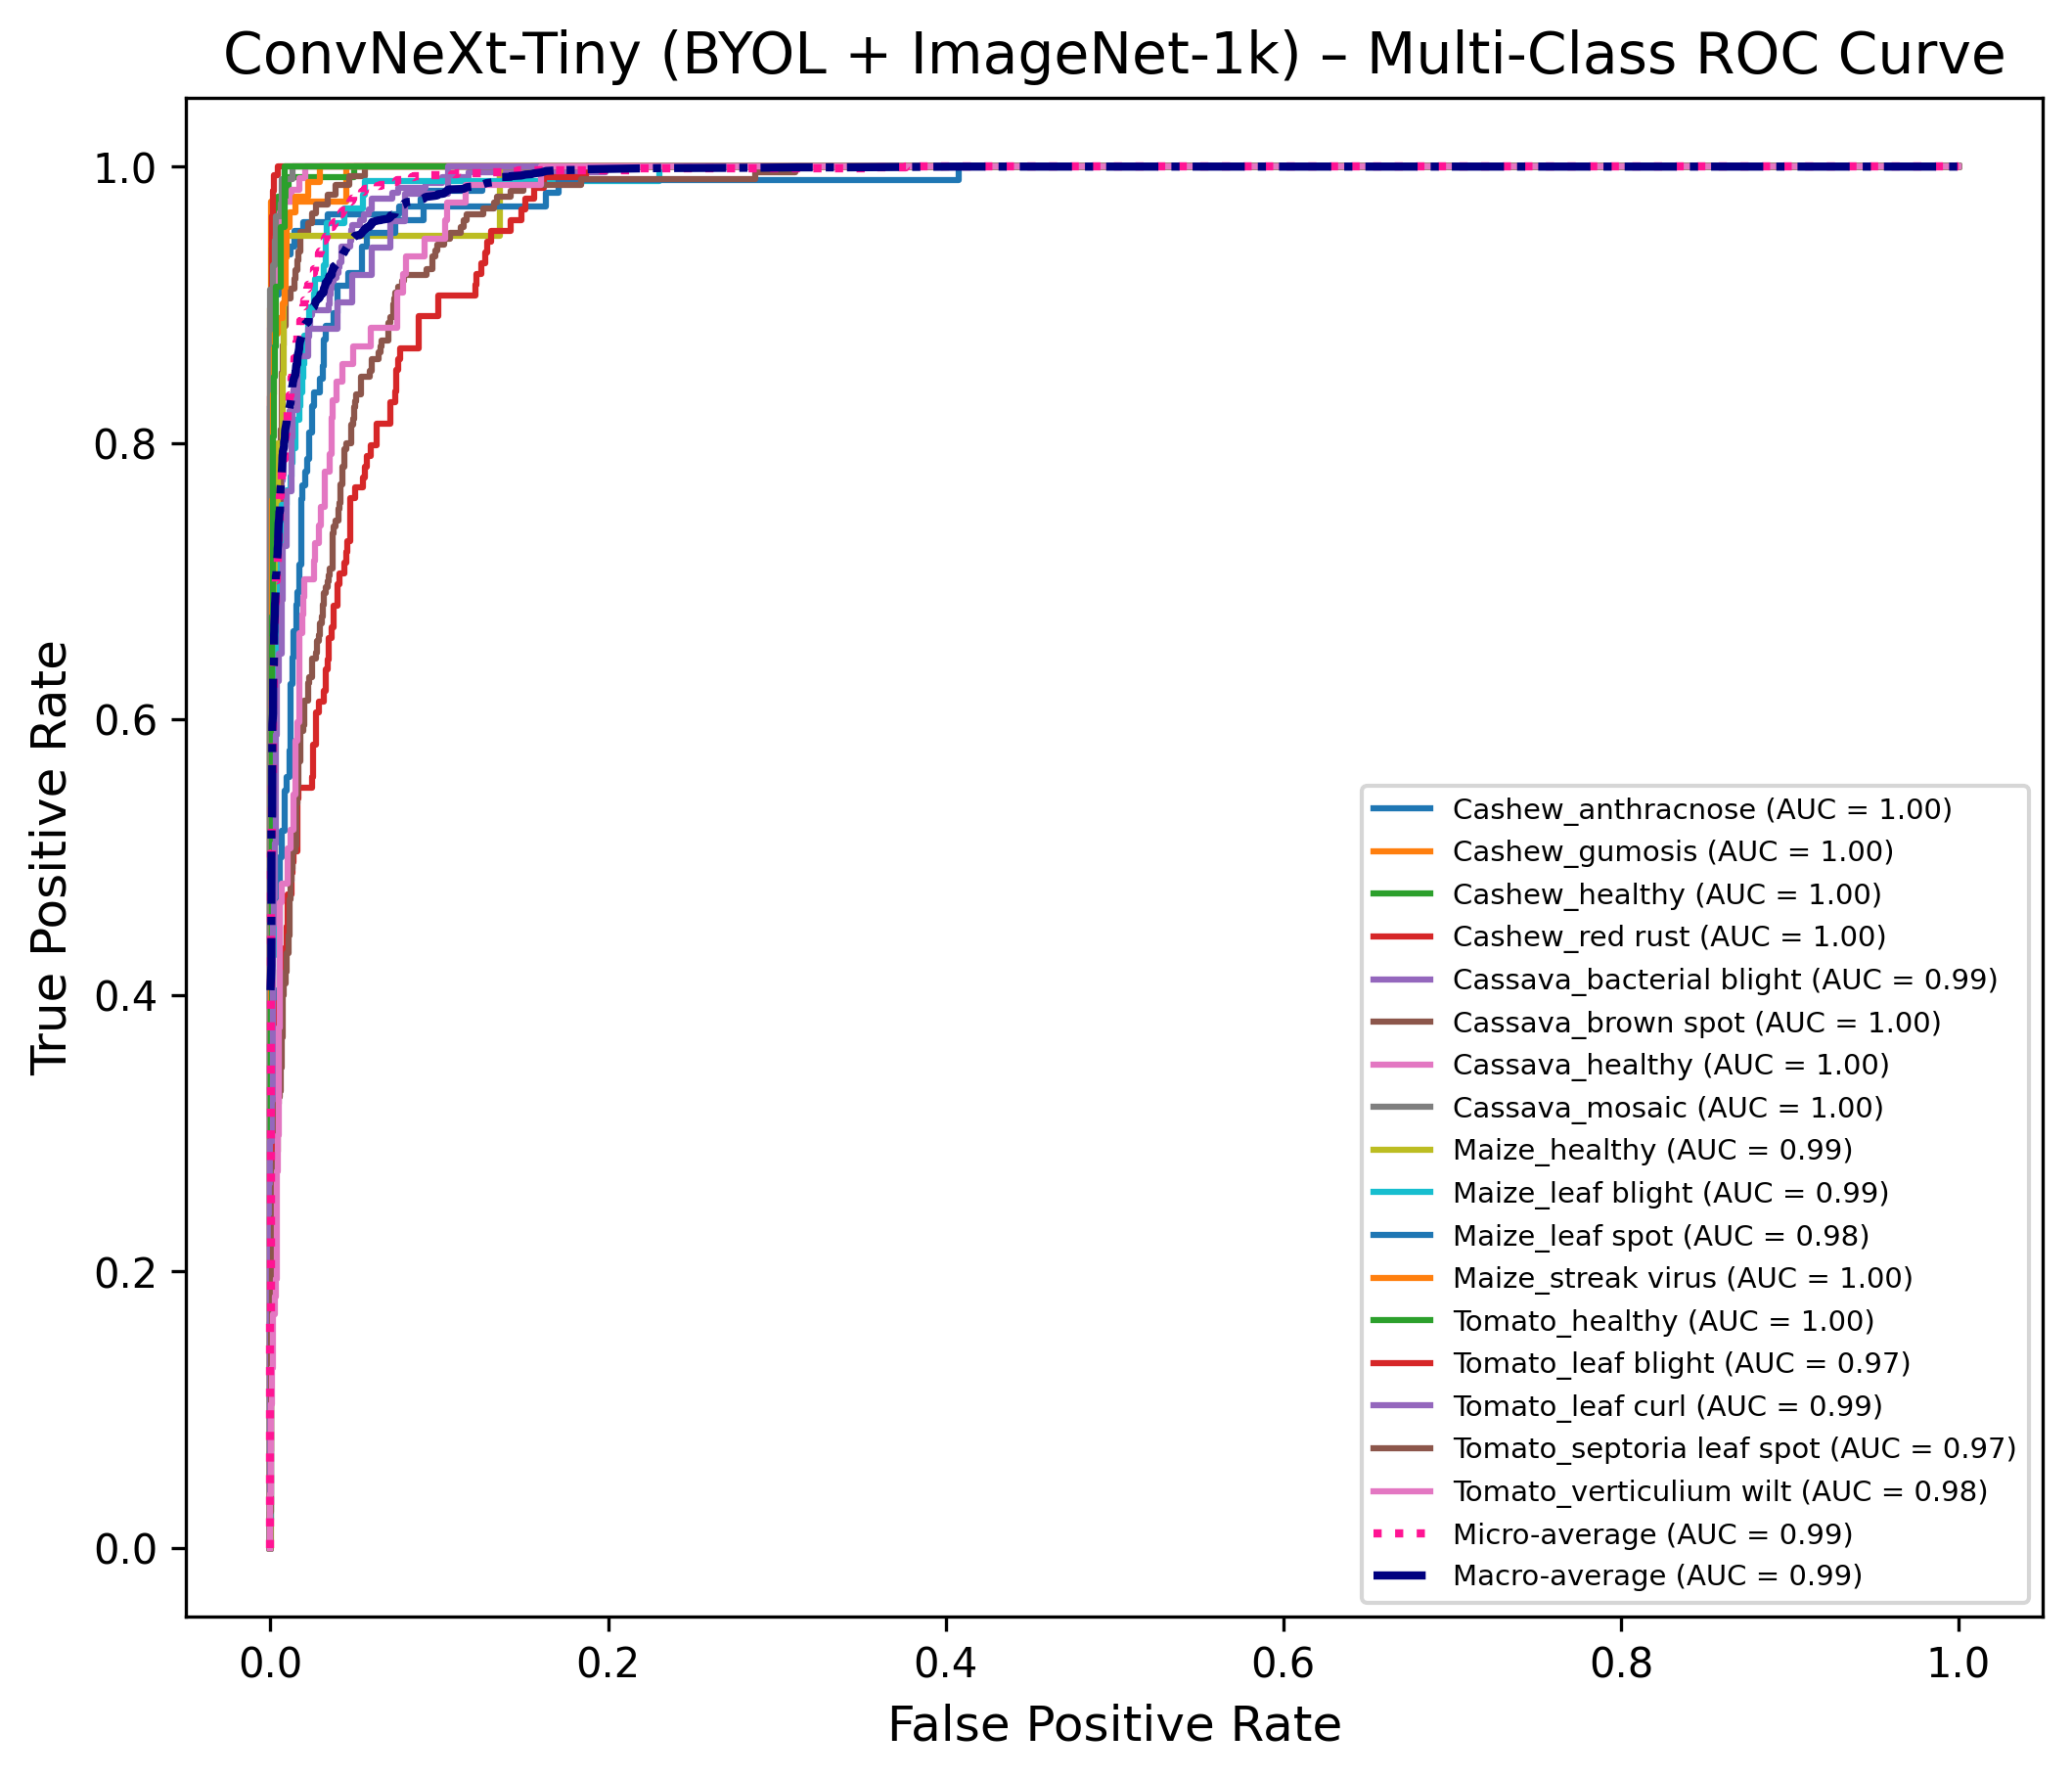

In [59]:
# define paths to predictions, targets, and where to save plots
version_dir = r"c:/users/xuxu/desktop/master thesis/byolbaselineimagenet/single_run/version_0"
index_dir = r"c:/users/xuxu/desktop/master thesis/optunadensenetfull"
save_dir = os.path.join(version_dir, "figures")

# create directory to save plots if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# file paths for predictions, labels, probabilities, and metrics
preds_path = os.path.join(version_dir, "all_preds.npy")
targets_path = os.path.join(version_dir, "all_targets.npy")
probs_path = os.path.join(version_dir, "all_probs.npy")
metrics_path = os.path.join(version_dir, "test_metrics.json")

# load class index mapping and reverse it to get class names
with open(os.path.join(index_dir, "class_to_idx.json")) as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# load predicted labels, true labels, and class probabilities
all_preds = np.load(preds_path)
all_targets = np.load(targets_path)
all_probs = np.load(probs_path)

# print classification report to the console
print("\n# classification report")
print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

# generate and save the confusion matrix heatmap
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="greens",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"fontsize": 6}
)
plt.title("convnext-tiny (byol + imagenet-1k) – confusion matrix", fontsize=14)
plt.xlabel("predicted label", fontsize=12)
plt.ylabel("true label", fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(save_dir, "confusion_matrix_absolute_cleaned.png"), bbox_inches="tight")
plt.show()

# prepare for multi-class roc curve calculation
n_classes = len(class_names)
y_true_bin = label_binarize(all_targets, classes=list(range(n_classes)))

# compute roc curves and auc for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# compute micro-average roc curve and auc
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# compute macro-average roc curve and auc
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot multi-class roc curves
plt.figure(figsize=(7, 6), dpi=300)

# plot roc for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (auc = {roc_auc[i]:.2f})",
             linewidth=1.5)

# plot micro-average and macro-average roc curves
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average (auc = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=2)
plt.plot(fpr["macro"], tpr["macro"],
         label=f"macro-average (auc = {roc_auc['macro']:.2f})",
         color='navy', linestyle='-.', linewidth=2)

# final formatting of the plot
plt.title("convnext-tiny (byol + imagenet-1k) – multi-class roc curve", fontsize=14)
plt.xlabel("false positive rate", fontsize=12)
plt.ylabel("true positive rate", fontsize=12)
plt.legend(loc="lower right", fontsize=7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=0.5)
plt.savefig(os.path.join(save_dir, "roc_curve_byol.png"), bbox_inches="tight", dpi=300)
plt.show()


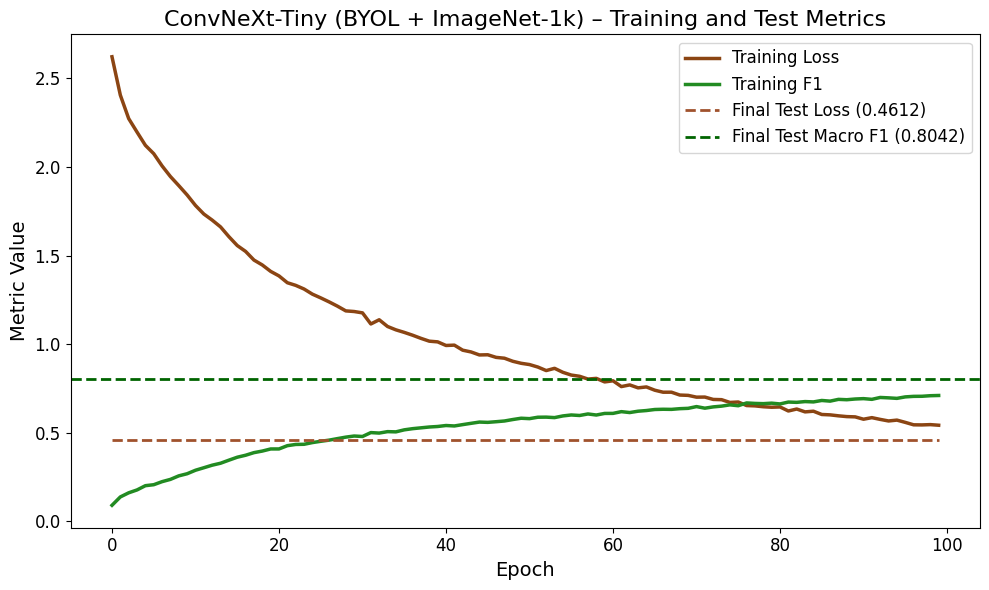

In [65]:
# load training metrics
df = pd.read_csv(metrics_path)
df_epoch = df.dropna(subset=["train_loss", "train_f1"]).reset_index(drop=True)

# load predictions and compute macro f1-score
all_preds = np.load(preds_path)
all_targets = np.load(targets_path)
report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
macro_f1 = report["macro avg"]["f1-score"]

# plot training loss and f1, along with final test metrics
plt.figure(figsize=(10, 6))

# plot training loss
plt.plot(
    df_epoch["epoch"],
    df_epoch["train_loss"],
    label="training loss",
    linestyle="-",
    color="#8B4513",  # saddlebrown
    linewidth=2.5
)

# plot training f1-score
plt.plot(
    df_epoch["epoch"],
    df_epoch["train_f1"],
    label="training f1",
    linestyle="-",
    color="#228B22",  # forestgreen
    linewidth=2.5
)

# plot final test loss, if available
if "test_loss" in df.columns and not df["test_loss"].isnull().all():
    test_loss = df["test_loss"].dropna().values[-1]
    plt.hlines(
        y=test_loss,
        xmin=df_epoch["epoch"].min(),
        xmax=df_epoch["epoch"].max(),
        label=f"final test loss ({test_loss:.4f})",
        colors="#A0522D",  # sienna
        linestyles="--",
        linewidth=2.0
    )

# plot final test macro f1-score
plt.axhline(
    y=macro_f1,
    xmin=0,
    xmax=1,
    label=f"final test macro f1 ({macro_f1:.4f})",
    color="#006400",  # darkgreen
    linestyle="--",
    linewidth=2.0
)

# final plot formatting
plt.xlabel("epoch", fontsize=14)
plt.ylabel("metric value", fontsize=14)
plt.title("convnext-tiny (byol + imagenet-1k) – training and test metrics", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()

# save and display the plot
save_path = os.path.join(save_dir, "convnext_training_metrics.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

